# Implementing Diffusion Models

## Preprocess data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Build the diffusion model

Build a simple diffusion model with an encoder that compresses the input image into a latent representation and a decoder that reconstructs the image from this representation. The model is compiled with the Adam optimizer and binary cross-entropy loss. 

In [2]:
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(28*28*32, activation='relu')(x)
x = Reshape((28,28,32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

diffusion_model.compile(optimizer='adam', loss='mean_squared_error')

diffusion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

## Add noise to the data

Add random noise to the data set to simulate the diffusion process: 

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)

## Train the diffusion model

Train the diffusion model to denoise the MINIST images. Use the noisy images as input and the original images as the target, learning to reverse the noise addition process. 

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0606

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, None, 28, 28)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, None, 28, 28, 1), dtype=float64)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

## Evaluate the diffusion model

Evaluate the performance of the trained diffusion model by predicting the denoised images and visualizing the results. Comparing the original, noisy, and denoised images will help you understand how well the model has learned to remove noise from the images. 

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


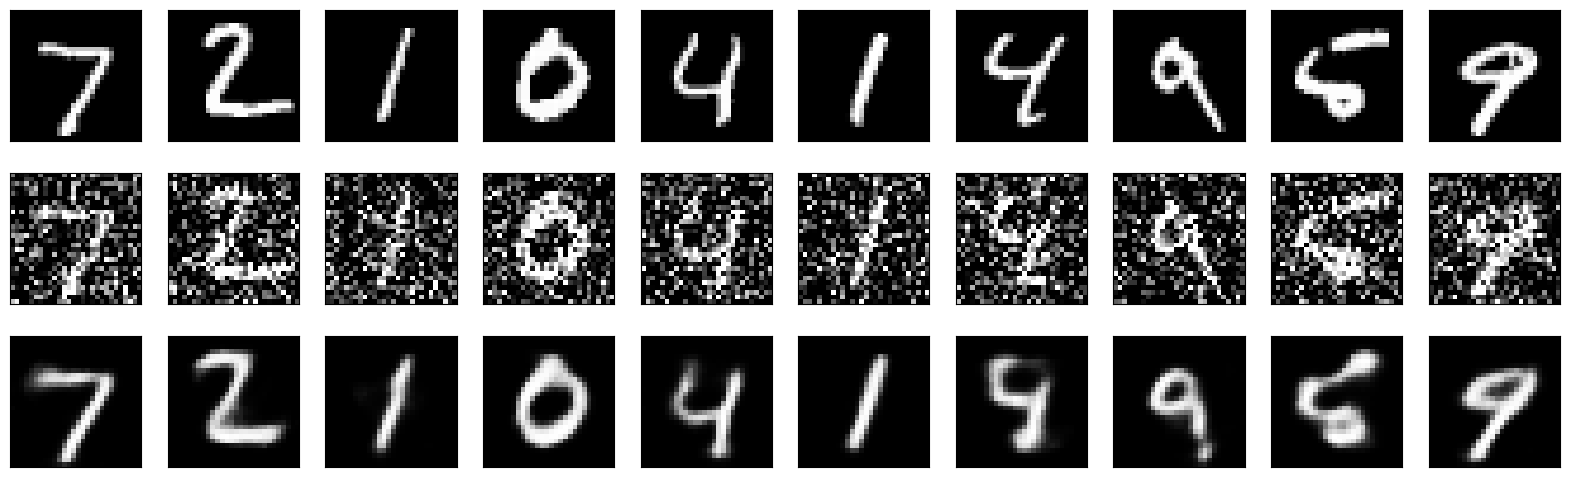

In [5]:
import matplotlib.pyplot as plt

denoised_images = diffusion_model.predict(x_test_noisy)

n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Fine-tune the diffusion model

In [ ]:
for layer in diffusion_model.layers:
  layer.trainable = False

for layer in diffusion_model.layers[-4:]:
  layer.trainable = True

diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

diffusion_model.fit(
  x_train_noisy, 
  x_train,
  epochs=10,
  batch_size=64,
  shuffle=True,
  validation_data=(x_test_noisy, x_test)
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - loss: 0.0950 - val_loss: 0.0962
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - loss: 0.0941 - val_loss: 0.0960
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - loss: 0.0938 - val_loss: 0.0956
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 0.0936 - val_loss: 0.0954
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 0.0934 - val_loss: 0.0953
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - loss: 0.0933 - val_loss: 0.0954
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 0.0933 - val_loss: 0.0952
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 0.0932 - val_loss: 0.0951
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 0.0931 - val_loss: 0.0952
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - loss: 0.0931 - val_loss: 0.0952


# Exercise 1

**Objective:**
Change the noise factor and see how it affects the model’s ability to denoise images.


1. Change the noise factor to 0.3.  
2. Add noise to the training and test data sets with the new noise factor.  
3. Retrain the model with the new noisy data.

In [6]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

diffusion_model.fit(
    x_train_noisy,
    x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - loss: 0.0122 - val_loss: 0.0107
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 12/50
469/469 ━━━━━━━━━━

KeyboardInterrupt: 

# Exercise 2

**Objective:**
Experiment with adding more layers to the model to see how it affects performance.


1. Add an additional Conv2D layer with 128 filters in the encoder.  
2. Add an additional Conv2DTranspose layer with 128 filters in the decoder.  
3. Rebuild, compile, and train the model.

In [15]:
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(28*28*64, activation='relu')(x)
x = Reshape((28,28,64))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

diffusion_model = Model(input_layer, output_layer)
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

diffusion_model.fit(
    x_train_noisy,
    x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/50
 12/469 ━━━━━━━━━━━━━━━━━━━━ 4:27 585ms/step - loss: 0.6285

KeyboardInterrupt: 

# Exercise 3

**Objective:**
Compare the impact of different noise levels on the denoising performance of the model.


1. Add noise with different factors (e.g., 0.1, 0.5, 0.7) to the test data.  
2. Use the model to predict the denoised images for each noise level.  
3. Visualize the original, noisy, and denoised images side by side for each noise level.

In [18]:
import matplotlib.pyplot as plt

# Function to add noise and predict denoised images
def add_noise_and_predict(noise_factor):
  x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
  x_test_noisy = np.clip(x_test_noisy, 0., 1.)
  denoised_images = diffusion_model.predict(x_test_noisy)
  return x_test_noisy, denoised_images

# Noise levels to test
noise_levels = [0.1, 0.5, 0.7]

# Visualize the results
n = 5
plt.figure(figsize=(20, 12))
for idx, noise_factor in enumerate(noise_levels):
  x_test_noisy, denoised_images = add_noise_and_predict(noise_factor)
  
  for i in range(n):
    # Display original
    ax = plt.subplot(3 * len(noise_levels), n, i + 1 + idx * 3 * n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if i == 0:
      ax.set_title(f'Original (Noise: {noise_factor})')

    # Display noisy
    ax = plt.subplot(3 * len(noise_levels), n, i + 1 + n + idx * 3 * n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Display denoised
    ax = plt.subplot(3 * len(noise_levels), n, i + 1 + 2 * n + idx * 3 * n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

 63/313 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step

KeyboardInterrupt: 

<Figure size 2000x1200 with 0 Axes>